In [1]:
from itertools import product
from pathlib import Path

import pandas as pd
import numpy as np
import Bio
from Bio import motifs
from Bio import Align

In [2]:
bed_90 = "beds/locations-8-0.90-tae.bed.gz"
bed_85 = "beds/locations-8-0.85-tae.bed.gz"

In [3]:
def read_input(location, offset=1):
    df = pd.read_csv(location, sep="\t", header=None, names=[
    "chr", "start", "end", "motif", "score"
    ])
    diff_prev = df["start"].diff(1)
    offset_1 = diff_prev == 1
    df["offset_1"] = offset_1 | offset_1.shift(-1)
    df["subgroup"] = (df.start.diff() != 1).cumsum() - 1
    return df

In [4]:
def get_unique_motifs(df):
    if "score" not in df:
        df["score"] = np.nan
    df_motifs = df.groupby("motif")[["motif", "score"]].agg(
    {
        'motif': 'size',
        'score': 'mean',
    }
    ).rename(columns={'motif': 'count'}).sort_values('count', ascending=False).reset_index()
    return df_motifs

## Mergeable motifs 

In [5]:
def get_offset_percentage(n):
    return (diff_prev == n).mean()

def get_offset_counts(n):
    return (diff_prev == n).sum()

In [6]:
df_90 = read_input(bed_90)
df_90

,chr,start,end,motif,score,offset_1,subgroup
0,chr1A,65400,65408,NGCTGCTG,1.000000,True,0
1,chr1A,65401,65409,GCTGCWGS,1.000000,True,0
2,chr1A,65446,65454,TGCADGTG,1.000000,False,1
3,chr1A,65467,65475,RTGCATGS,1.000000,False,2
4,chr1A,65474,65482,GGCGGMGG,1.000000,True,3
...,...,...,...,...,...,...,...
12680228,chrUn,478934399,478934407,GCAGCARS,0.919954,True,6606369
12680229,chrUn,478935090,478935098,TGCAASCA,0.855321,False,6606370
12680230,chrUn,478935556,478935564,TTGCWTGC,1.000000,True,6606371
12680231,chrUn,478935557,478935565,TGCTTGCW,1.000000,True,6606371


In [7]:
df_85 = read_input(bed_85)
df_85

,chr,start,end,motif,score,offset_1,subgroup
0,chr1A,65272,65280,SCARCAGC,1.0,False,0
1,chr1A,65283,65291,MTGCKGCT,1.0,False,1
2,chr1A,65398,65406,VYTGCTGC,1.0,True,2
3,chr1A,65399,65407,YKGCTGCT,1.0,True,2
4,chr1A,65400,65408,BGCTGCWG,1.0,True,2
...,...,...,...,...,...,...,...
45317805,chrUn,478935738,478935746,SMTCCATG,1.0,True,21633630
45317806,chrUn,478935739,478935747,CTSCATGY,1.0,True,21633630
45317807,chrUn,478935833,478935841,YATGCMTG,1.0,True,21633631
45317808,chrUn,478935834,478935842,ATGCMTGK,1.0,True,21633631


In [8]:
get_unique_motifs(df_90).shape

(918, 3)

In [9]:
get_unique_motifs(df_85).shape

(5185, 3)

<AxesSubplot:ylabel='Frequency'>

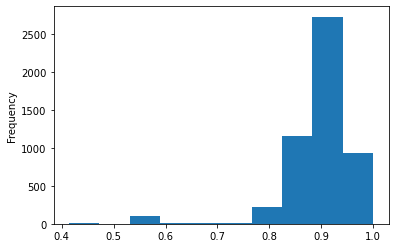

In [10]:
get_unique_motifs(df_85).score.plot.hist()

<AxesSubplot:ylabel='Frequency'>

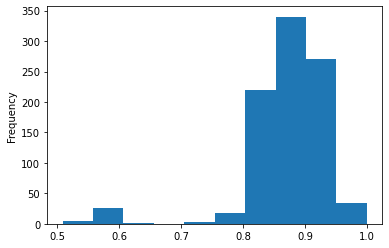

In [11]:
get_unique_motifs(df_90).score.plot.hist()

## Merged motif lengths

In [12]:
df_mergable = df[df.offset_1].reset_index()
df_mergable

NameError: name 'df' is not defined

In [ ]:
subgroups = df.subgroup.value_counts()
subgroups

## Merge methods

In [ ]:
def ambiguous_dna_list(seq):
    """return list of all possible sequences given an ambiguous DNA input"""
    d = Bio.Data.IUPACData.ambiguous_dna_values
    return list(map("".join, product(*map(d.get, seq))))


def is_degen_mergable(str1, str2):
    for s1, s2 in product(ambiguous_dna_list(str1), ambiguous_dna_list(str2)):
        if s1 == s2:
            return True
    return False

def degen_merge(motifs):
    consensus = list(Bio.motifs.create(motifs, alphabet="GATCRYWSMKHBVDN").consensus)
    return "".join(consensus)

def degen_merge_with_offset(motifs, offset=1):
    motifs = [
        "N"*i + m + "N"*(len(motifs)-i-1)
        for i, m in enumerate(motifs)
    ]    
    return motifs[0][0] + degen_merge(motifs)[1:-1] + motifs[-1][-1]

def get_merge_type(motifs : pd.Series, offset=1):
    """
    >>> get_merge_type(pd.Series(["AAA", "AAB", "ABA"]))
    perfect
    >>> get_merge_type(pd.Series(["AAA", "AAB", "MBA"]))
    degen
    >>> get_merge_type(pd.Series(["SWGCAGCA", "WGCAGCAR"]))
    perfect
    
    """
    motif = motifs.iloc[0]
    output = "perfect"
    for m in motifs.iloc[1:]:
        prev_substring = motif[-(len(m)-offset):]
        curr_substring = m[:-offset]
        if output == "perfect":
            if curr_substring != prev_substring:
                output = "degen"
        if output == "degen":
            if not is_degen_mergable(prev_substring, curr_substring):
                # unknown
                return "unknown"
        motif = m
    return output

def do_merge(motifs : pd.Series, offset=1):
    merge_type = get_merge_type(motifs)
    if merge_type == "perfect":
        return motifs.iloc[0] + motifs.iloc[1:].str[-1].str.cat()
    elif merge_type == "degen":
        return degen_merge_with_offset(motifs)
    else:
        return None

In [ ]:
def merge_motifs(df, n=100_000):
    df_mergable = df[df.offset_1].reset_index()
    df_mergable.head(n).groupby("subgroup").agg({
        'motif': degen_merge_with_offset,
    })
    return df_mergable

In [ ]:
N = 100_000
df_mergable_with_type = df_mergable.head(N).copy().reset_index()
df_merge_type = df_mergable_with_type.head(N).groupby(by="subgroup").agg({
    'motif': get_merge_type
})
df_mergable_with_type = df_mergable_with_type.join(
    df_merge_type.rename(columns={"motif": "merge_type"}),
    on="subgroup",
    how="inner",
)
df_mergable_with_type

In [ ]:
def get_counts_and_percentage(df):
    return pd.concat([
        df.value_counts(), 
        df.value_counts(normalize=True) * 100,
    ],axis=1, keys=('counts','percentage'))

In [ ]:
get_counts_and_percentage(df_mergable_with_type["merge_type"])

In [ ]:
df_merged_motifs = df_merged.groupby("motif").agg(
    {
        'motif': 'size',
    }
    ).rename(columns={'motif': 'count'}).sort_values('count', ascending=False).reset_index()
df_merged_motifs

## Compare motifs

In [ ]:
def load_jaspar(location="jaspar"):
    jaspar_motifs = []
    for location in Path("jaspar").iterdir():
        with open(str(location)) as fh:
            for m in motifs.parse(fh, "jaspar"):
                jaspar_motifs.append(m)
    return jaspar_motifs

In [ ]:
jaspar_motifs = load_jaspar("jaspar")
len(jaspar_motifs)

In [ ]:
df_jaspar = pd.DataFrame([str(m.degenerate_consensus.strip("N")) for m in jaspar_motifs], columns=["motif"])
df_jaspar["motif_length"] = df_jaspar["motif"].apply(len)
df_jaspar

In [ ]:
df_jaspar.motif_length.value_counts().sort_index().plot.bar()

In [ ]:
df_jaspar_8 = df_jaspar[df_jaspar.motif_length == 8]

In [ ]:
len(df_jaspar_8)

In [ ]:
matched_motifs = df_motifs.motif.str.contains(df_jaspar.motif.str.cat(sep="|"), regex=True)
matched_motifs.mean()

In [ ]:
def motif_to_regex(m):
    output = []
    for c in m:
        poss = ambiguous_dna_list(c)
        if len(poss) == 1:
            output.append(poss[0])
        else:
            output.append(f"[{''.join(poss)}]")
    return "".join(output)

In [ ]:
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = Align.substitution_matrices.load("NUC.4.4")
aligner.mode = 'global'
aligner.target_left_extend_gap_score = -2.5
aligner.target_right_extend_gap_score = -2.5
aligner.query_left_extend_gap_score = -2.5
aligner.query_right_extend_gap_score = -2.5
aligner.target_left_open_gap_score = -2.5
aligner.target_right_open_gap_score = -2.5
aligner.query_left_open_gap_score = -2.5
aligner.query_right_open_gap_score = -2.5
aligner.query_internal_open_gap_score = -2.5
aligner.query_internal_extend_gap_score = -2.5
aligner.target_internal_open_gap_score = -2.5
aligner.target_internal_extend_gap_score = -2.5
aligner.open_gap_score = -2.5
aligner.extend_gap_score = -2.5

In [ ]:
def score(seq, motif, max_score=5):
    return aligner.score(seq, motif) / (max_score * len(motif))

def get_best_motif(seq):
    jaspar_scores = df_jaspar.motif.apply(lambda m: score(seq, m))
#     adjusted_scores = jaspar_scores * df_jaspar.motif_length
    i = np.argmax(jaspar_scores)
    return pd.Series({
        "match_score": jaspar_scores[i],
        "jaspar_motif": df_jaspar.motif[i],
        "motif": seq,
    })

In [ ]:
aligner.score("AAA", "ANA")

In [ ]:
score("AAABCAAA", "A")

In [ ]:
get_best_motif("AAAAGAAABA")

In [ ]:
score("AABA", "AAMN")

In [ ]:
from Bio.Align import substitution_matrices 

## Compare motifs after merge

In [ ]:
df_merged_motifs = df_merged_motifs.motif.apply(get_best_motif)
df_merged_motifs

In [ ]:
df_merged_motifs

In [ ]:
get_unique_motifs(df_merged_motifs)

In [ ]:
plot_jaspar_matches(df_85)

In [ ]:
plot_jaspar_matches(df_90)

In [ ]:
plot_jaspar_matches(df_85, cumulative=True)

In [ ]:
plot_jaspar_matches(df_90, cumulative=True)

In [ ]:
deg

In [ ]:
plot_unique_motifs(df_merged_motifs)

In [ ]:
def plot_unique_motifs(df):
    df_unique = get_unique_motifs(df)
    return df_unique.motif.apply(get_best_motif).match_score.plot.hist(logy=True, bins=30)

In [ ]:
def get_jaspar_matches(df):
    df = get_unique_motifs(df).motif.apply(get_best_motif)
    df = df.sort_values(by="match_score", ascending=False)
    return df

In [ ]:
def plot_jaspar_matches(df, agg="max", **kwargs):
    return get_jaspar_matches(df).groupby("jaspar_motif").agg({'match_score': agg}).hist(**kwargs)

In [ ]:
plot_unique_motifs(df_90)

In [ ]:
plot_unique_motifs(df_85)

In [ ]:
df_90_jaspar = get_jaspar_matches(df_90)
df_90_jaspar                      

In [ ]:
df_90_jaspar.

In [ ]:
df_merged_motifs.sort_values(by="match_score", ascending=False)[:100]

In [ ]:
df_merged_motifs.sort_values(by="match_score", ascending=False)[:100]

In [ ]:
df_merged_motifs.sort_values(by="match_score", ascending=False)[-100:]

In [ ]:
df_motifs.motif.apply(get_best_motif).sort_values(by="match_score", ascending=False)[:100]

## Lookup motif

In [ ]:
def get_motif_name(motif):
    for location in Path("jaspar").iterdir():
        with open(str(location)) as fh:
            for m in motifs.parse(fh, "jaspar"):
                if m.degenerate_consensus == motif:
                    print(location)

In [ ]:
get_motif_name("GCGCCGCC")

- [Jaspar entry](http://jaspar.genereg.net/matrix/MA0975.1/)
- CRF2 (term in [STRING](https://string-db.org/network/3702.AT4G23750.1))
- class: AP2/ERF domain
- stress response
- [chr1A:174,364-174,422](https://bioinformatics.psb.ugent.be/plaza/versions/plaza_v4_5_monocots/igv/show_region/tae)
- 44 motifs